In [1]:
using PyPlot
using JLD
using Distances
code_path = "../src/"
push!(LOAD_PATH, code_path)
using AnomalyDetection
using MultivariateStats
using ScikitLearn.Utils: meshgrid

In [2]:
dataset = load("toy_data_3.jld")["data"]

AnomalyDetection.Dataset([0.803442 0.804605 … 0.252366 -0.216809; 0.821998 0.834235 … 0.714171 1.09756], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [3]:
X = dataset.data;
Y = dataset.labels;
tstX = X + randn(size(X))/10;

In [4]:
# model parameters
k = 3 # number of nearest neighbors
metric = Euclidean() # any of metric from Distance package
weights = "distance" # "distance" # uniform/distance
threshold = 0.5
reduced_dim = false # if dim > 10, use PCA to reduce it
#model = kNN(k, metric = metric, weights = weights, reduced_dim = reduced_dim)
model = kNN(k, metric = metric, weights = weights, threshold = threshold,
    reduced_dim = reduced_dim)

AnomalyDetection.kNN(3, Array{Float64}(0,0), Int64[], Distances.Euclidean(0.0), "distance", 0.5, false, (Array{Float64}(0,0), Float64[]), false)

In [5]:
AnomalyDetection.fit!(model, X, Y);

In [6]:
# this fits the model and produces predicted labels
tryhat, tstyhat = AnomalyDetection.rocstats(X, Y, tstX, Y, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 90
  fp = 0
  fn = 0
precision: 1.0
f1score: 1.0
recall: 1.0
false positive rate: 0.0
equal error rate: 0.0

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 11
  tn = 84
  fp = 6
  fn = 2
precision: 0.6470588235294118
f1score: 0.7333333333333333
recall: 0.8461538461538461
false positive rate: 0.06666666666666667
equal error rate: 0.11025641025641025


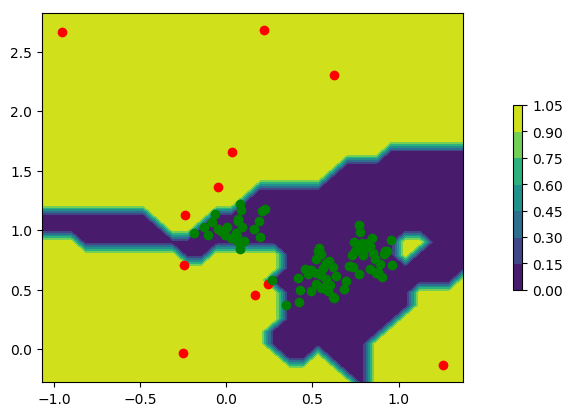

In [7]:
# plot heatmap of the fit
figure()
scatter(tstX[1,:], tstX[2,:], c = "r")
ax = gca()
_ylim = ax[:get_ylim]()
_xlim = ax[:get_xlim]()
xx, yy = meshgrid(linspace(_xlim[1], _xlim[2], 30), linspace(_ylim[1], _ylim[2], 30))
zz = zeros(size(xx))
for i in 1:size(xx, 1)
    for j in 1:size(xx, 2)
        zz[i,j] = AnomalyDetection.predict(model, [xx[i,j], yy[i,j]])[1]
    end
end
axsurf = ax[:contourf](xx, yy, zz)
cb = colorbar(axsurf, fraction = 0.05, shrink = 0.5, pad = 0.1)
scatter(tstX[1, tryhat.==1], tstX[2, tryhat.==1], c = "r", label = "predicted positive")
scatter(tstX[1, tstyhat.==0], tstX[2, tstyhat.==0], c = "g", label = "predicted negative")
show()

In [8]:
# 
using MLBase: recall, false_positive_rate
kvec = [1, 2, 3, 4, 5, 6, 7, 9, 11, 15]
nk = size(kvec,1)
recvec = Array{Float64,1}(nk)
fprvec = Array{Float64,1}(nk)
for i in 1:nk
    model.k = kvec[i]
    _,_,_,tstroc = AnomalyDetection.rocstats(X,Y,tstX,Y,model, verb = false)
    recvec[i] = recall(tstroc)
    fprvec[i] = false_positive_rate(tstroc)
end

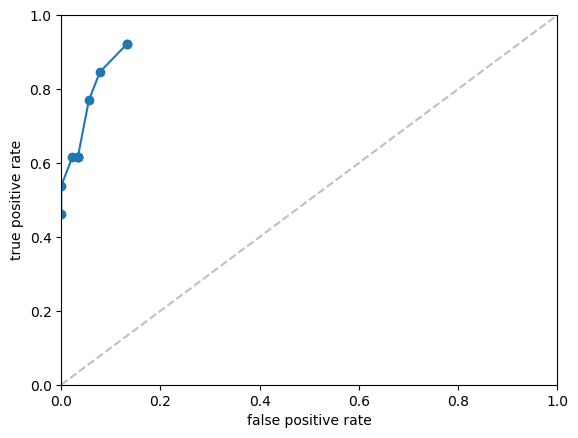

In [9]:
figure()
plot(linspace(0,1,100), linspace(0,1,100), "--", c = "gray", alpha = 0.5)
xlim([0, 1])
ylim([0, 1])
xlabel("false positive rate")
ylabel("true positive rate")
scatter(fprvec, recvec)
plot(fprvec, recvec)
show()